In [1]:
#import for data process
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
# Load dataset from directory
dataset_dir = '/content/drive/MyDrive/DogsWolves'
batch_size = 32
img_size = (224, 224)

dataset = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                       image_size=img_size,
                                       batch_size=batch_size,
                                       label_mode='int')

Found 2000 files belonging to 2 classes.


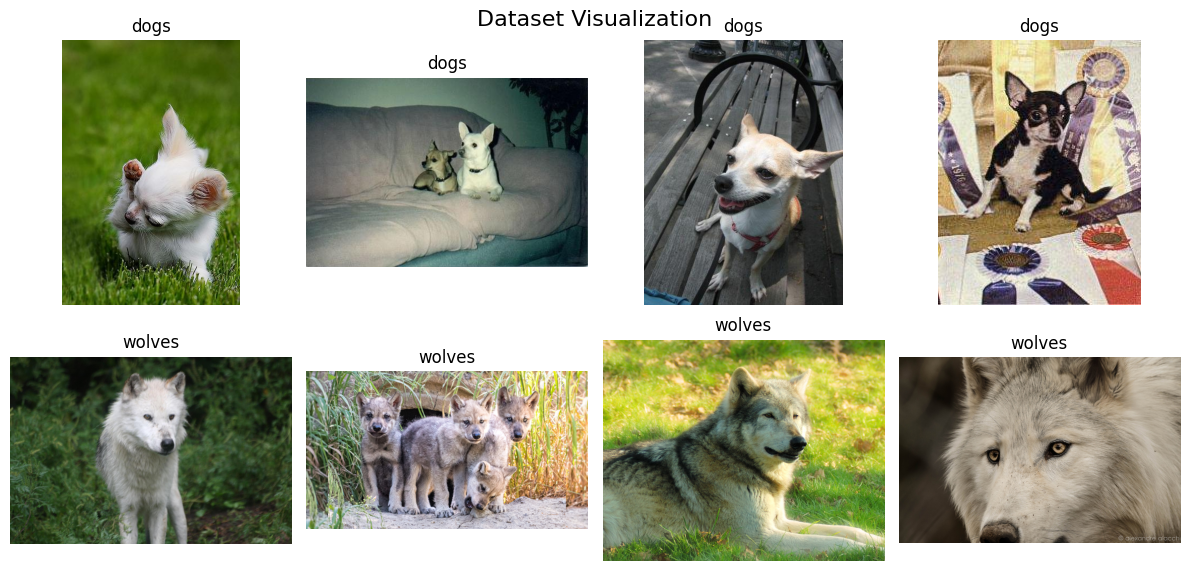

In [3]:
#dataset visualization

def load_images_from_folder(folder, num_images=3):
    images = []
    filenames = os.listdir(folder)
    for filename in filenames[:num_images]:
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
            images.append(img)
    return images

def visualize_dataset(dataset_dir, num_images=4):
    class_names = os.listdir(dataset_dir)
    num_classes = len(class_names)
    fig, axes = plt.subplots(num_classes, num_images, figsize=(num_images * 3, num_classes * 3))
    fig.suptitle('Dataset Visualization', fontsize=16)

    for class_idx, class_name in enumerate(class_names):
        class_folder = os.path.join(dataset_dir, class_name)
        images = load_images_from_folder(class_folder, num_images)
        for img_idx, img in enumerate(images):
            ax = axes[class_idx, img_idx]
            ax.imshow(img)
            ax.axis('off')
            ax.set_title(class_name, fontsize=12)

    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()

visualize_dataset(dataset_dir)

In [4]:
# Load images and labels from directory
def load_images_from_directory(directory):
    images = []
    labels = []
    class_names = sorted(os.listdir(directory))
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(directory, class_name)
        for filename in os.listdir(class_folder):
            img_path = os.path.join(class_folder, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, img_size)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                img = img.astype('float32') / 255.0  # Normalize pixel values
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels), class_names

# Load data
images, labels, class_names = load_images_from_directory(dataset_dir)

# Print the class names
print("Class names:", class_names) # Verify the shapes of images and labels
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

Class names: ['dogs', 'wolves']
Images shape: (2000, 224, 224, 3)
Labels shape: (2000,)


In [5]:
from sklearn.model_selection import train_test_split
# Split data using sklearn train_test_split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Print the number of files in each split
print("Number of training samples:", len(X_train))
print("Number of testing samples:", len(X_test))

Number of training samples: 1600
Number of testing samples: 400


In [6]:
from keras import layers, applications, models, optimizers, callbacks
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#define data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

def preprocess_and_augment(image, label):
    image = data_augmentation(image)
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.xception.preprocess_input(image)
    return image, label

def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.keras.applications.xception.preprocess_input(image)
    return image, label

# Convert to TensorFlow datasets and apply augmentation to training data
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
    .map(preprocess_and_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
    .map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
    .batch(batch_size) \
    .prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

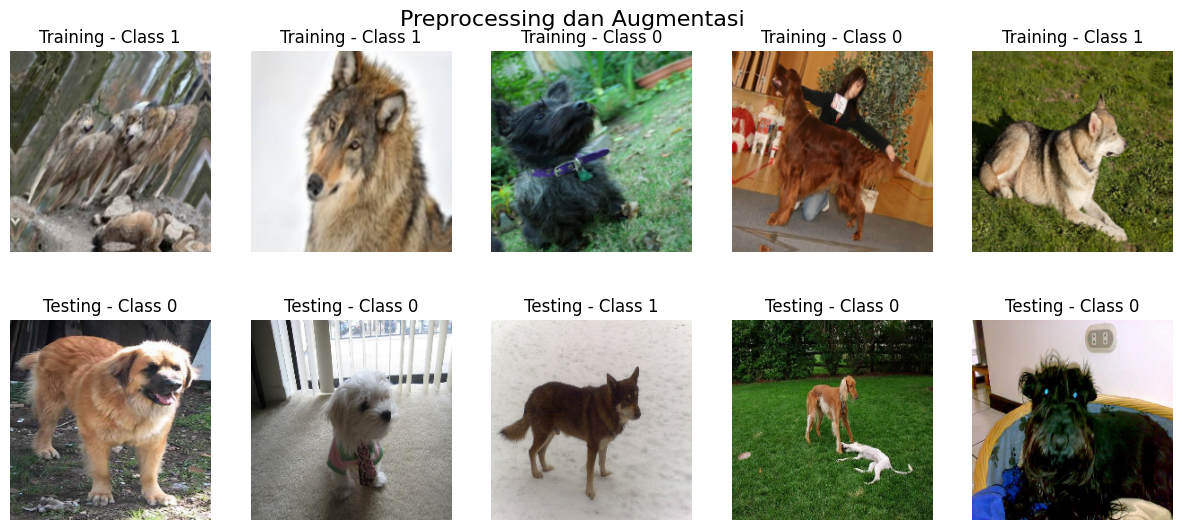

In [11]:
def visualize_dataset_from_split(train_ds, test_ds, num_images=5):
    datasets = {'Training': train_ds, 'Testing': test_ds}
    fig, axes = plt.subplots(len(datasets), num_images, figsize=(num_images * 3, len(datasets) * 3))
    fig.suptitle('Preprocessing dan Augmentasi', fontsize=16)

    for ds_idx, (ds_name, ds) in enumerate(datasets.items()):
        for images, labels in ds.take(1):
            for img_idx in range(num_images):
                ax = axes[ds_idx, img_idx]

                # Convert the image back to the range [0, 255] for visualization
                img = images[img_idx].numpy()
                img = (img - img.min()) / (img.max() - img.min()) * 255  # Normalize to [0, 255]
                img = img.astype("uint8")

                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f"{ds_name} - Class {labels[img_idx].numpy()}", fontsize=12)

    plt.subplots_adjust(top=0.93)
    plt.show()

visualize_dataset_from_split(train_ds, test_ds)


In [12]:
base_model = Xception(weights='imagenet',
                            include_top=False,
                            input_shape=(img_size[0], img_size[1], 3))

for layer in base_model.layers:
    layer.trainable = False

# Add new layers for fine-tuning
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(2, activation='softmax')(x)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [13]:
# Define the model
model = Model(inputs=base_model.input, outputs=predictions)
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1          │ (None, 224, 224, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv1 (Conv2D)  │ (None, 111, 111, 32) │          864 │ input_layer_1[0][0] │    N    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv1_bn        │ (None, 111, 111, 32) │          128 │ block1_conv1[0][0]  │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv1_act       │ (None, 111, 111, 32) │            0 │ block1_conv1_bn[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv2 (Conv2D)  │ (None, 109, 109, 64) │       18,432 │ block1_conv1_act[0… │    N    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv2_bn        │ (None, 109, 109, 64) │          256 │ block1_conv2[0][0]  │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv2_act       │ (None, 109, 109, 64) │            0 │ block1_conv2_bn[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv1        │ (None, 109, 109,     │        8,768 │ block1_conv2_act[0… │    N    │
│ (SeparableConv2D)      │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv1_bn     │ (None, 109, 109,     │          512 │ block2_sepconv1[0]… │    N    │
│ (BatchNormalization)   │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv2_act    │ (None, 109, 109,     │            0 │ block2_sepconv1_bn… │    -    │
│ (Activation)           │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv2        │ (None, 109, 109,     │       17,536 │ block2_sepconv2_ac… │    N    │
│ (SeparableConv2D)      │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv2_bn     │ (None, 109, 109,     │          512 │ block2_sepconv2[0]… │    N    │
│ (BatchNormalization)   │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 55, 55, 128)  │        8,192 │ block1_conv2_act[0… │    N    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_pool            │ (None, 55, 55, 128)  │            0 │ block2_sepconv2_bn… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├──────────────────────

 Total params: 22,961,706 (87.59 MB)

 Trainable params: 2,100,226 (8.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

In [15]:
# Set up callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=1),
    ModelCheckpoint(filepath='best_model.keras', monitor='val_loss', save_best_only=True, verbose=1)
]

In [16]:
# Train the model on the new data for a few epochs
history = model.fit(
    train_ds,
    epochs=10,
    validation_data=test_ds,
    callbacks=callbacks
)

Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.5246 - loss: 0.6942
Epoch 1: val_loss improved from inf to 0.69371, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 52s 613ms/step - accuracy: 0.5244 - loss: 0.6942 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step - accuracy: 0.4900 - loss: 0.6985
Epoch 2: val_loss improved from 0.69371 to 0.69364, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 416ms/step - accuracy: 0.4902 - loss: 0.6985 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step - accuracy: 0.5071 - loss: 0.6971
Epoch 3: val_loss improved from 0.69364 to 0.69233, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 467ms/step - accuracy: 0.5071 - loss: 0.6971 - val_accuracy: 0.5000 - val_loss: 0.6923
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step - accuracy: 0.5093 - loss: 0.6971
Epoch 4: val_loss improved from 0.69233 to 0.69100,

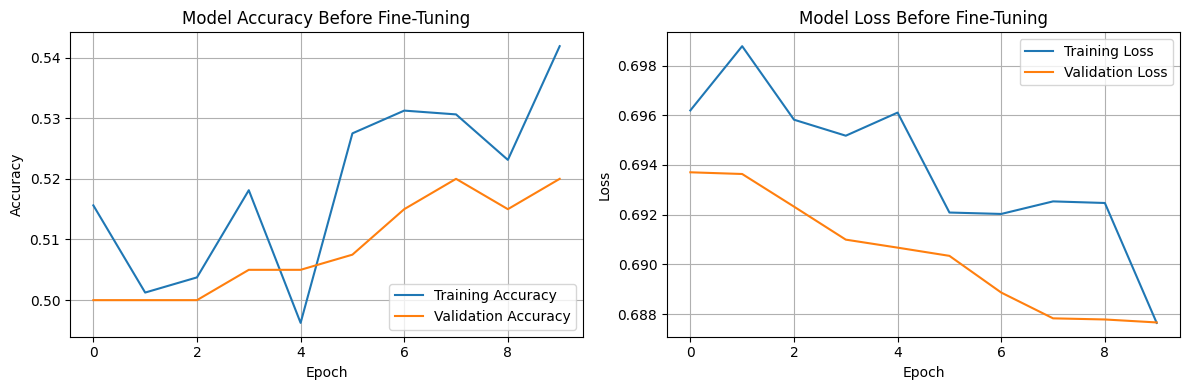

In [17]:
#history plot before fine tuning

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Before Fine-Tuning')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Before Fine-Tuning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 346ms/step
Classification Report:
               precision    recall  f1-score   support

        dogs       0.76      0.02      0.05       800
      wolves       0.50      0.99      0.67       800

    accuracy                           0.51      1600
   macro avg       0.63      0.51      0.36      1600
weighted avg       0.63      0.51      0.36      1600

Confusion Matrix:
 [[ 19 781]
 [  6 794]]


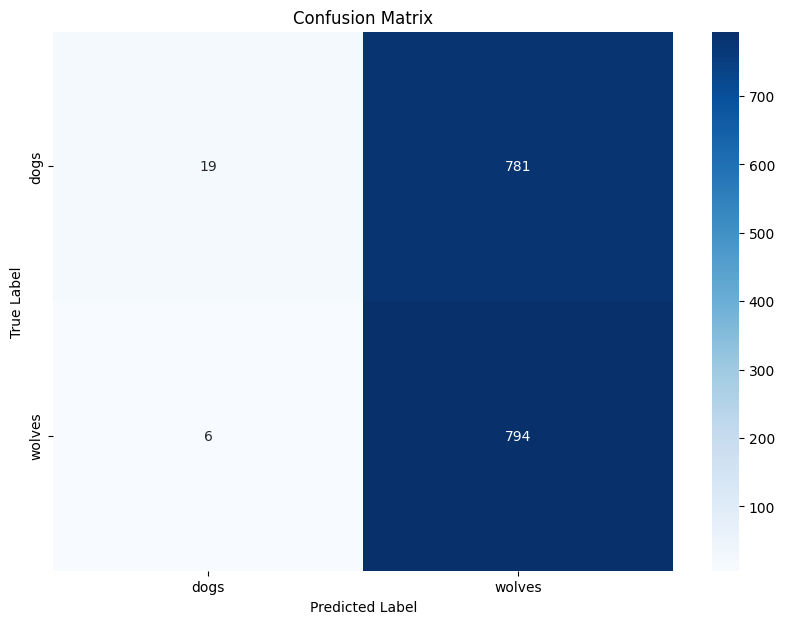

In [18]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Predict labels for the test set
y_pred_probs = model.predict(train_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate classification report
report = classification_report(y_train, y_pred, target_names=class_names)
print("Classification Report:\n", report)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_train, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Optional: visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
# Tahap kedua: Unfreeze model dasar untuk fine-tuning, kecuali lapisan BatchNormalization
for layer in base_model.layers:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
model.compile(optimizer=Adam(learning_rate=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┓
┃ Layer (type)           ┃ Output Shape         ┃      Param # ┃ Connected to        ┃ Traina… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━┩
│ input_layer_1          │ (None, 224, 224, 3)  │            0 │ -                   │    -    │
│ (InputLayer)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv1 (Conv2D)  │ (None, 111, 111, 32) │          864 │ input_layer_1[0][0] │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv1_bn        │ (None, 111, 111, 32) │          128 │ block1_conv1[0][0]  │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv1_act       │ (None, 111, 111, 32) │            0 │ block1_conv1_bn[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv2 (Conv2D)  │ (None, 109, 109, 64) │       18,432 │ block1_conv1_act[0… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv2_bn        │ (None, 109, 109, 64) │          256 │ block1_conv2[0][0]  │    N    │
│ (BatchNormalization)   │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block1_conv2_act       │ (None, 109, 109, 64) │            0 │ block1_conv2_bn[0]… │    -    │
│ (Activation)           │                      │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv1        │ (None, 109, 109,     │        8,768 │ block1_conv2_act[0… │    Y    │
│ (SeparableConv2D)      │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv1_bn     │ (None, 109, 109,     │          512 │ block2_sepconv1[0]… │    N    │
│ (BatchNormalization)   │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv2_act    │ (None, 109, 109,     │            0 │ block2_sepconv1_bn… │    -    │
│ (Activation)           │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv2        │ (None, 109, 109,     │       17,536 │ block2_sepconv2_ac… │    Y    │
│ (SeparableConv2D)      │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_sepconv2_bn     │ (None, 109, 109,     │          512 │ block2_sepconv2[0]… │    N    │
│ (BatchNormalization)   │ 128)                 │              │                     │         │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ conv2d (Conv2D)        │ (None, 55, 55, 128)  │        8,192 │ block1_conv2_act[0… │    Y    │
├────────────────────────┼──────────────────────┼──────────────┼─────────────────────┼─────────┤
│ block2_pool            │ (None, 55, 55, 128)  │            0 │ block2_sepconv2_bn… │    -    │
│ (MaxPooling2D)         │                      │              │                     │         │
├──────────────────────

 Total params: 22,961,706 (87.59 MB)

 Trainable params: 22,852,650 (87.18 MB)

 Non-trainable params: 109,056 (426.00 KB)

In [21]:
# Fine-tune the model
fine_tune_epochs = 10
total_epochs = 10 + fine_tune_epochs

history_fine = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    callbacks=callbacks
)

# Load the best model
model.load_weights('best_model.keras')

Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 609ms/step - accuracy: 0.5055 - loss: 0.6943
Epoch 10: val_loss improved from 0.68767 to 0.68576, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 73s 900ms/step - accuracy: 0.5058 - loss: 0.6942 - val_accuracy: 0.5175 - val_loss: 0.6858
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 655ms/step - accuracy: 0.5547 - loss: 0.6808
Epoch 11: val_loss improved from 0.68576 to 0.66313, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 37s 737ms/step - accuracy: 0.5552 - loss: 0.6806 - val_accuracy: 0.5675 - val_loss: 0.6631
Epoch 12/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 633ms/step - accuracy: 0.6091 - loss: 0.6482
Epoch 12: val_loss improved from 0.66313 to 0.62369, saving model to best_model.keras
50/50 ━━━━━━━━━━━━━━━━━━━━ 39s 702ms/step - accuracy: 0.6092 - loss: 0.6483 - val_accuracy: 0.6750 - val_loss: 0.6237
Epoch 13/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 657ms/step - accuracy: 0.6900 - loss: 0.5997
Epoch 13: val_loss improved from 0.62369

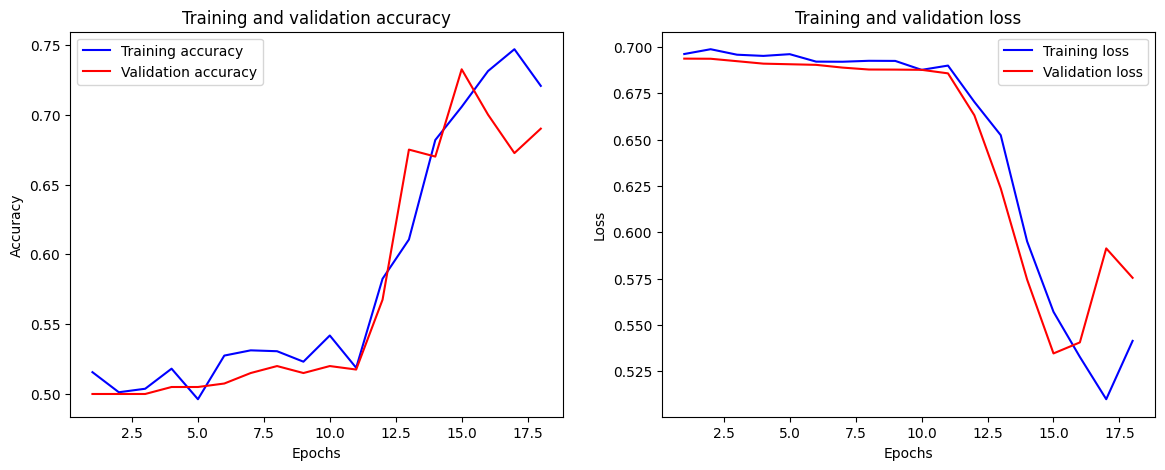

In [22]:
# Plotting after the fine tuning
def plot_training_history(history, fine_tune=False):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    if fine_tune:
        acc += history_fine.history['accuracy']
        val_acc += history_fine.history['val_accuracy']
        loss += history_fine.history['loss']
        val_loss += history_fine.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')  # Menambahkan teks sumbu X
    plt.ylabel('Accuracy')  # Menambahkan teks sumbu Y
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')  # Menambahkan teks sumbu X
    plt.ylabel('Loss')  # Menambahkan teks sumbu Y
    plt.legend()

    plt.show()

# Plotting the training and fine-tuning history
plot_training_history(history, fine_tune=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 282ms/step
Classification Report:
               precision    recall  f1-score   support

        dogs       0.83      0.59      0.69       200
      wolves       0.68      0.88      0.77       200

    accuracy                           0.73       400
   macro avg       0.75      0.73      0.73       400
weighted avg       0.75      0.73      0.73       400

Confusion Matrix:
 [[118  82]
 [ 25 175]]


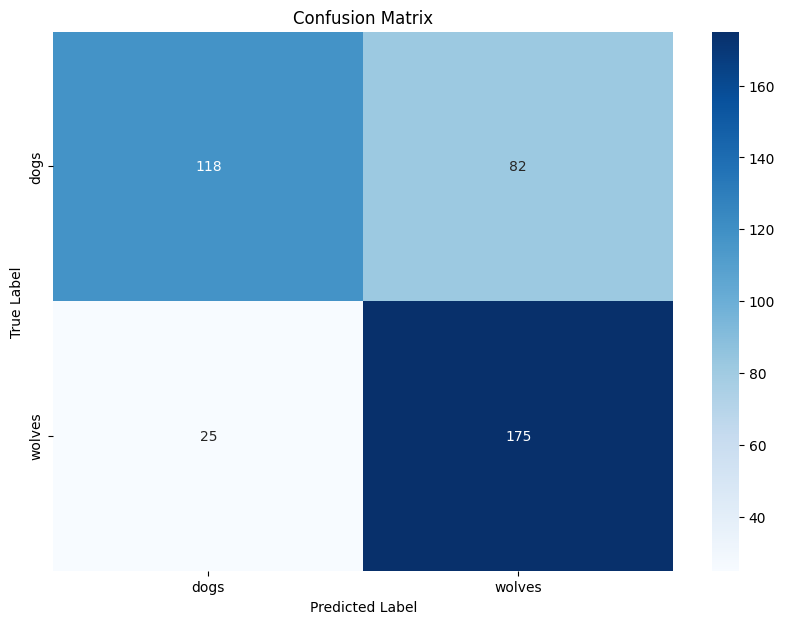

In [23]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Predict labels for the test set
y_pred_probs = model.predict(test_ds)
y_pred = np.argmax(y_pred_probs, axis=1)

# Calculate classification report
report = classification_report(y_test, y_pred, target_names=class_names)
print("Classification Report:\n", report)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Optional: visualize the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()